# Forecasting the stock price
We are using historical data of RIL (M/s.Reliance India Limited) share price between Jan 2020 to Apr 2023 and apply a LSTM model to forecast stock price for Mar & Apr 2023

## Content

1. **[Import packages](#import_packages)**
2. **[Load data](#load_data)**
3. **[Data preparation](#data_preparation)**
    - 3.1 - [Dimensions of Dataset](#data_dimension)
    - 3.2 - [Statistical Summary](#Stat_sum)
    - 3.3 - [Checking Data Type and Missing Values](#check_data_type)
    - 3.4 - [Dropping unrequired columns](#Dropping_unrequired_columns)
    - 3.5 - [Indexing with Date](#Indexing_with_Date)
4. **[Time Series Analysis](#Time_Series_Analysis)**
    - 4.1 - [Visualizing data](#Visualizing_data)
    - 4.2 - [Sampling](#Sampling)
    - 4.3 - [Scaling of dataset](#Scaling_of_dataset)
    - 4.4 - [Time Series Generator](#Generating_Time_Series)
    - 4.5 - [Finding Y value respective to X days value](#Finding_Y_Value)
5. **[Time Series Forcasting using LSTM](#Time_Series_Forcasting_using_LSTM)**
    - 5.1 - [Parameter Selection](#Parameter_Selection)
    - 5.2 - [Fitting the LSTM model](#Fitting_the_LSTM)
    - 5.3 - [Validating Forecasts](#Validating_Forecasts)
    - 5.4 - [Calculating RMSE](#Calculating_RMSE)
    - 5.5 - [Comparing the predictions](#Comparing_the_predictions)
    - 5.6 - [Visualizing the Forecast](#Visualizing_the_Forecast)
6. **[Conclusion](#Conclusion)**

# 1. Import Packages

In [2]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

# 2. Load Dataset

In [3]:
df = pd.read_csv(r"C:\Users\Tejas\Downloads\RIL.csv")

# 3.Data Preparation

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,01-01-2020,1503.745972,1512.760498,1491.363403,1495.424927,1480.595825,6463060
1,02-01-2020,1497.802368,1526.480469,1497.802368,1520.883545,1505.802124,8173308
2,03-01-2020,1518.605103,1527.173950,1508.699097,1522.716187,1507.616577,9684434
3,06-01-2020,1505.727173,1513.552979,1483.933838,1487.400879,1472.651367,11315596
4,07-01-2020,1504.736572,1520.091064,1499.288208,1510.284058,1495.307617,7699489


In [5]:
df.shape

(826, 7)

In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,826.000000,826.000000,826.000000,826.000000,826.000000,8.260000e+02
mean,2177.527100,2202.209299,2150.889277,2175.331816,2167.033872,1.048096e+07
std,401.073323,401.125154,400.570712,401.120987,404.357074,8.459998e+06
min,907.596863,941.079529,867.427673,875.748779,867.064636,7.871600e+05
25%,1987.399963,2006.387482,1965.075012,1985.450012,1973.142822,5.245060e+06
50%,2259.500000,2284.750000,2226.824951,2252.875000,2245.653199,7.683476e+06
75%,2474.924988,2502.875000,2454.650024,2478.562561,2473.789611,1.250563e+07
max,2856.149902,2856.149902,2786.100098,2819.850098,2811.385742,6.584835e+07


# 3.3 Checking for null values

In [7]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# 3.4 Dropping all columns except 'Close' & 'Date'

In [8]:
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'],axis=1)

# 3.5 Indexing with Date

In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.index

C:\Users\Tejas\AppData\Local\Temp\ipykernel_9088\2422507133.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-01-13', '2020-01-14',
               ...
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-24', '2023-04-25', '2023-04-26',
               '2023-04-27', '2023-04-28'],
              dtype='datetime64[ns]', name='Date', length=826, freq=None)

# Time Series Analysis
# 4.1 Visulizing data

In [15]:
dfv = df.reset_index()
dfv = dfv.drop('Date',axis=1)

In [17]:
dfv

,Close
0,1495.424927
1,1520.883545
2,1522.716187
3,1487.400879
4,1510.284058
...,...
821,2358.000000
822,2376.050049
823,2362.100098
824,2377.050049


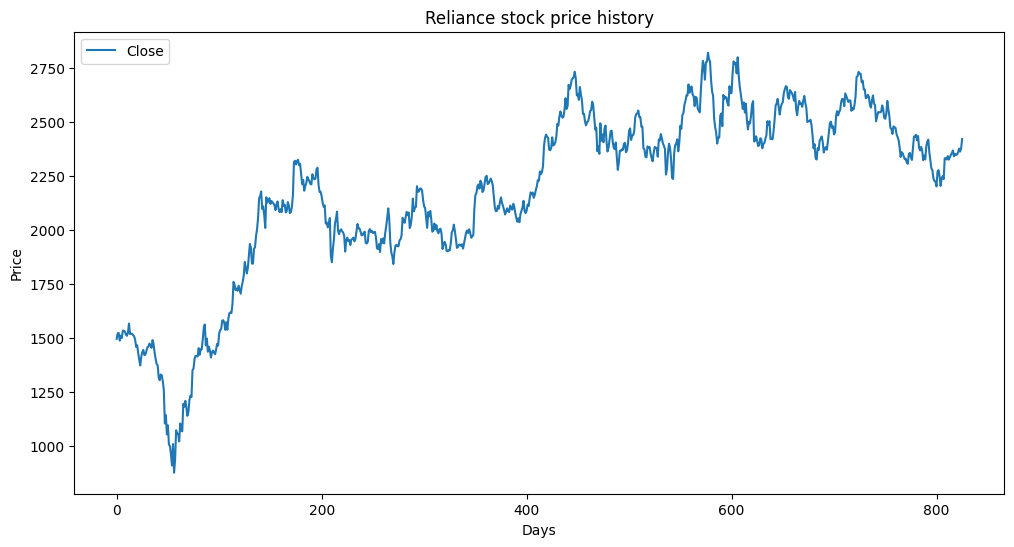

In [18]:
plt.figure(figsize = (12,6))
plt.plot(dfv["Close"])
plt.title('Reliance stock price history')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Close'], loc='upper left')
plt.show()

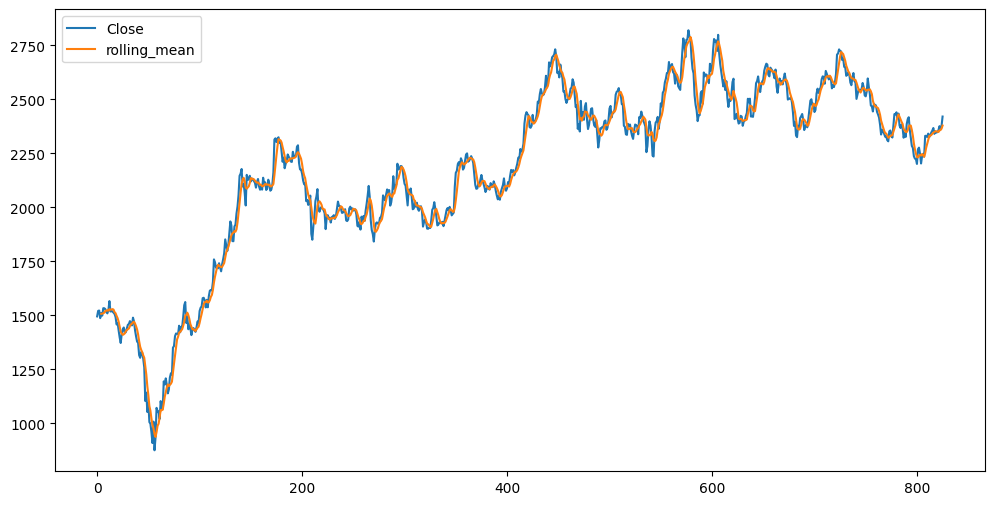

In [20]:
window_size = 5
rolling_mean = dfv.rolling(window_size).mean()

plt.figure(figsize = (12,6))
plt.plot(dfv['Close'], label='Actual Values')
plt.plot(rolling_mean['Close'], label='Rolling Mean')
plt.legend(['Close','rolling_mean'], loc='upper left')
plt.show()

In [111]:
df.head()

,Close
Date,
2020-01-01,1495.424927
2020-02-01,1520.883545
2020-03-01,1522.716187
2020-06-01,1487.400879
2020-07-01,1510.284058


In [112]:
data = df.reset_index()

In [113]:
data.head()

,Date,Close
0,2020-01-01,1495.424927
1,2020-02-01,1520.883545
2,2020-03-01,1522.716187
3,2020-06-01,1487.400879
4,2020-07-01,1510.284058


In [114]:
data.columns

Index(['Date', 'Close'], dtype='object')

In [115]:
data.drop('Date',axis=1)

,Close
0,1495.424927
1,1520.883545
2,1522.716187
3,1487.400879
4,1510.284058
...,...
821,2358.000000
822,2376.050049
823,2362.100098
824,2377.050049


In [116]:
data.head()

,Date,Close
0,2020-01-01,1495.424927
1,2020-02-01,1520.883545
2,2020-03-01,1522.716187
3,2020-06-01,1487.400879
4,2020-07-01,1510.284058


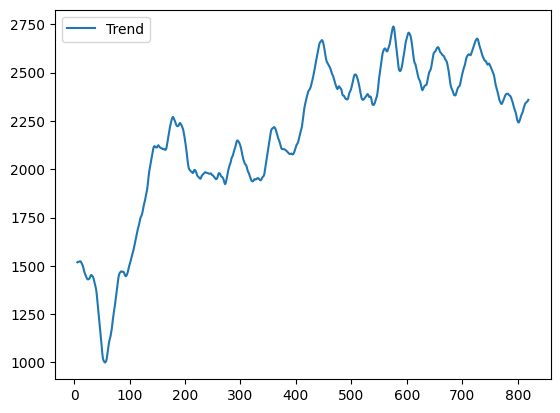

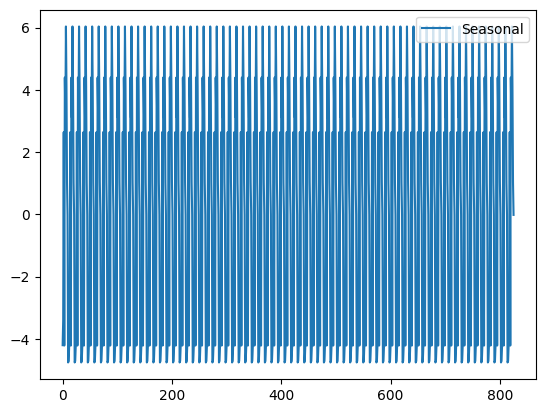

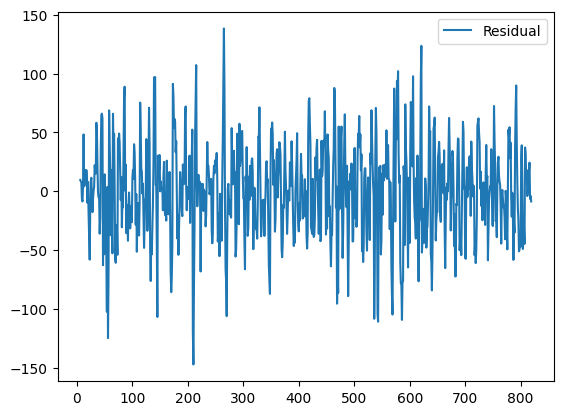

In [117]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['Close'], model='additive', period=12)

trend = result.trend
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.show()

seasonal = result.seasonal
plt.show()
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')

residual = result.resid
plt.show()
plt.plot(residual, label = 'Residual')
plt.legend(loc='best')


# 4.2 Sampling
Splitting data set into train and test

In [118]:
train_data = df.iloc[:788]
test_data = df.iloc[788:]

In [119]:
train_data.head()

,Close
Date,
2020-01-01,1495.424927
2020-02-01,1520.883545
2020-03-01,1522.716187
2020-06-01,1487.400879
2020-07-01,1510.284058


In [120]:
train_data.tail()

,Close
Date,
2023-02-22,2378.899902
2023-02-23,2367.500000
2023-02-24,2383.699951
2023-02-27,2367.850098
2023-02-28,2322.550049


In [121]:
test_data.head()

,Close
Date,
2023-01-03,2343.899902
2023-02-03,2326.050049
2023-03-03,2385.399902
2023-06-03,2408.699951
2023-08-03,2417.350098


In [122]:
test_data.tail()

,Close
Date,
2023-04-24,2358.000000
2023-04-25,2376.050049
2023-04-26,2362.100098
2023-04-27,2377.050049
2023-04-28,2420.500000


# 4.3 Scaling of dataset

In [123]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))


scale_train = scaler.fit_transform(train_data)
scale_test = scaler.fit_transform(test_data)

In [124]:
len(scale_train)

788

In [125]:
len(scale_test)

38

# Generating data in time series model (Sequential)

In [126]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 22
n_features = 1

generator  = TimeseriesGenerator(scale_train,scale_train,length= n_input,batch_size=1)

# 4.5 Finding Y Value

In [127]:
X,y = generator[0]
print(X.flatten())
print(y)

[0.31874684 0.33184215 0.33278482 0.31461946 0.32639003 0.32055569
 0.33831336 0.33813504 0.33612236 0.32883582 0.32600782 0.33316696
 0.35512843 0.33033902 0.33112879 0.33084856 0.32753651 0.32483591
 0.31719272 0.29946048 0.3035878  0.28519319]
[[0.26883675]]


In [128]:
X.shape

(1, 22, 1)

# 5.Time Series Forcasting using LSTM]

# 5.1 Parameter Selection

In [129]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics='accuracy')

In [130]:

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dense_7 (Dense)             (None, 25)                1275      
                                                                 
 dense_8 (Dense)             (None, 1)                 26        
                                                                 
Total params: 47,151
Trainable params: 47,151
Non-trainable params: 0
_________________________________________________________________


# 5.2 Fitting the LSTM model

In [131]:
model.fit(generator,epochs=20)

Epoch 1/20
766/766 [==============================] - 6s 6ms/step - loss: 0.0162 - accuracy: 0.0026
Epoch 2/20
766/766 [==============================] - 6s 8ms/step - loss: 0.0022 - accuracy: 0.0026
Epoch 3/20
766/766 [==============================] - 7s 9ms/step - loss: 0.0014 - accuracy: 0.0026
Epoch 4/20
766/766 [==============================] - 5s 7ms/step - loss: 0.0013 - accuracy: 0.0026
Epoch 5/20
766/766 [==============================] - 5s 6ms/step - loss: 0.0011 - accuracy: 0.0026
Epoch 6/20
766/766 [==============================] - 5s 6ms/step - loss: 9.2293e-04 - accuracy: 0.0026
Epoch 7/20
766/766 [==============================] - 5s 6ms/step - loss: 8.1881e-04 - accuracy: 0.0026
Epoch 8/20
766/766 [==============================] - 5s 7ms/step - loss: 8.5706e-04 - accuracy: 0.0026
Epoch 9/20
766/766 [==============================] - 5s 6ms/step - loss: 8.4045e-04 - accuracy: 0.0026
Epoch 10/20
766/766 [==============================] - 6s 7ms/step - loss: 6.9011e-0

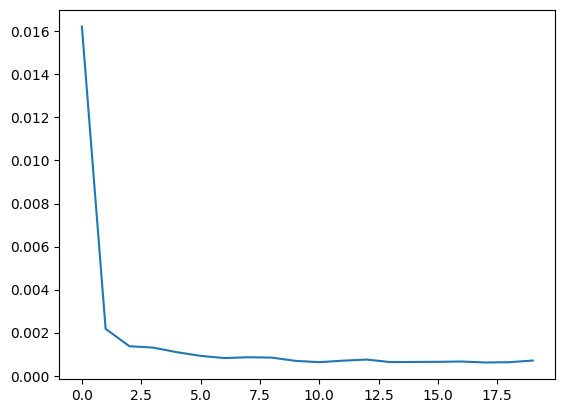

In [132]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

# 5.3 Validating Forecasts

In [133]:
test_predictions = []

first_eval_batch = scale_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [134]:
for i in range(len(scale_test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 26ms/step


In [135]:
print(test_predictions)
print(len(test_predictions))


[array([0.7306664], dtype=float32), array([0.71748465], dtype=float32), array([0.7052476], dtype=float32), array([0.69376147], dtype=float32), array([0.68293804], dtype=float32), array([0.6725668], dtype=float32), array([0.66267246], dtype=float32), array([0.65325606], dtype=float32), array([0.6443082], dtype=float32), array([0.63581437], dtype=float32), array([0.6277579], dtype=float32), array([0.62012196], dtype=float32), array([0.6128898], dtype=float32), array([0.6060454], dtype=float32), array([0.59957176], dtype=float32), array([0.59345275], dtype=float32), array([0.58767265], dtype=float32), array([0.58221644], dtype=float32), array([0.57706785], dtype=float32), array([0.57221216], dtype=float32), array([0.5676357], dtype=float32), array([0.56332475], dtype=float32), array([0.5592654], dtype=float32), array([0.55544454], dtype=float32), array([0.55184966], dtype=float32), array([0.5484686], dtype=float32), array([0.5452898], dtype=float32), array([0.5423022], dtype=float32), arr

In [136]:
true_predictions = scaler.inverse_transform(test_predictions)

In [137]:
true_predictions

array([[2361.44860798],
       [2358.55851017],
       [2355.87553214],
       [2353.35720184],
       [2350.98416512],
       [2348.71026465],
       [2346.54093687],
       [2344.47639087],
       [2342.51457492],
       [2340.65230034],
       [2338.88592109],
       [2337.21173882],
       [2335.62609442],
       [2334.12545942],
       [2332.70610936],
       [2331.3645158 ],
       [2330.09722869],
       [2328.90095483],
       [2327.77212656],
       [2326.707516  ],
       [2325.70413052],
       [2324.75895132],
       [2323.8689335 ],
       [2323.03121509],
       [2322.24303867],
       [2321.50173831],
       [2320.80479182],
       [2320.14975543],
       [2319.53432912],
       [2318.95629126],
       [2318.41394298],
       [2317.90596437],
       [2317.42970258],
       [2316.98153767],
       [2316.55940485],
       [2316.16148762],
       [2315.78621779],
       [2315.43217091]])

# 5.5 Comparing the predicitons

In [138]:
test_data['Predictions'] = true_predictions

C:\Users\Tejas\AppData\Local\Temp\ipykernel_17496\441470350.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predictions'] = true_predictions


In [139]:
test_data.head()

,Close,Predictions
Date,,
2023-01-03,2343.899902,2361.448608
2023-02-03,2326.050049,2358.558510
2023-03-03,2385.399902,2355.875532
2023-06-03,2408.699951,2353.357202
2023-08-03,2417.350098,2350.984165


In [140]:
test_data.reset_index(inplace=True)

In [141]:
test_data.columns

Index(['Date', 'Close', 'Predictions'], dtype='object')

In [142]:
test_data.drop('Date',axis=1)

,Close,Predictions
0,2343.899902,2361.448608
1,2326.050049,2358.558510
2,2385.399902,2355.875532
3,2408.699951,2353.357202
4,2417.350098,2350.984165
5,2359.250000,2348.710265
6,2322.699951,2346.540937
7,2284.500000,2344.476391
8,2275.949951,2342.514575
9,2237.050049,2340.652300


# 5.4 Calculating RMSE

In [143]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test_data['Close'],test_data['Predictions']))
print(rmse)

64.25242731739397


# 5.6 Visualizing the Forecast

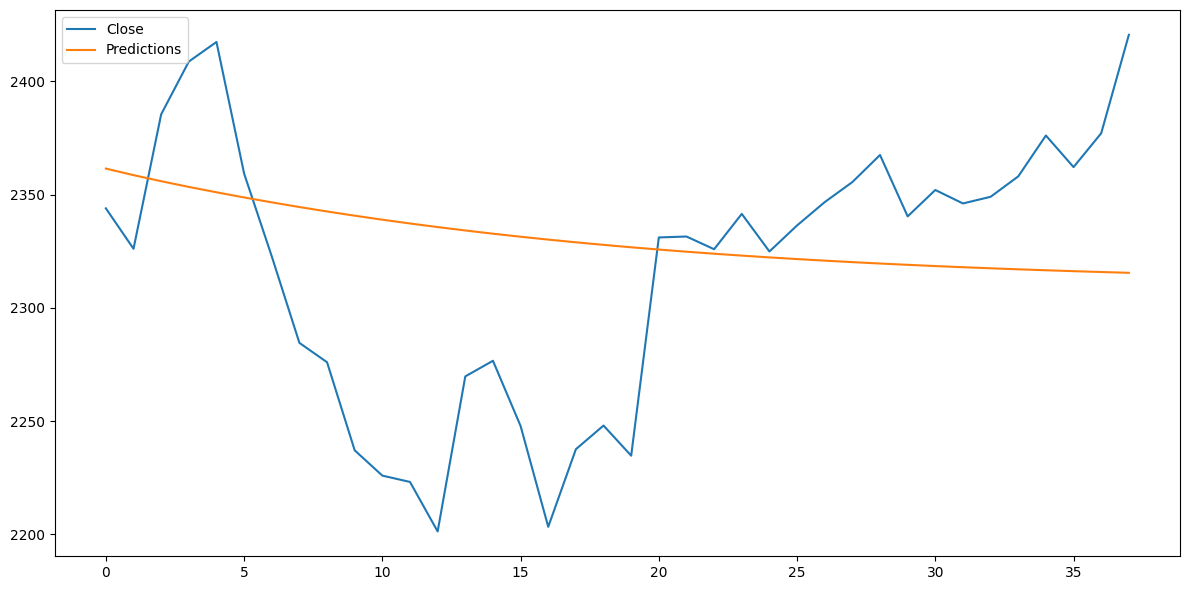

In [144]:
plt.figure(figsize = (12,6))
plt.plot(test_data['Close'],label ='Actual Values')
plt.plot(test_data['Predictions'], label  ='Predictions')
plt.legend(['Close','Predictions'], loc='upper left')
plt.tight_layout()
plt.show()

In [145]:
df1 = df

In [146]:
df1.reset_index(inplace= True)

In [147]:
df1.columns
df1.drop('Date',axis=1)
df1 = df1.iloc[:788]

In [148]:
df1.shape

(788, 2)

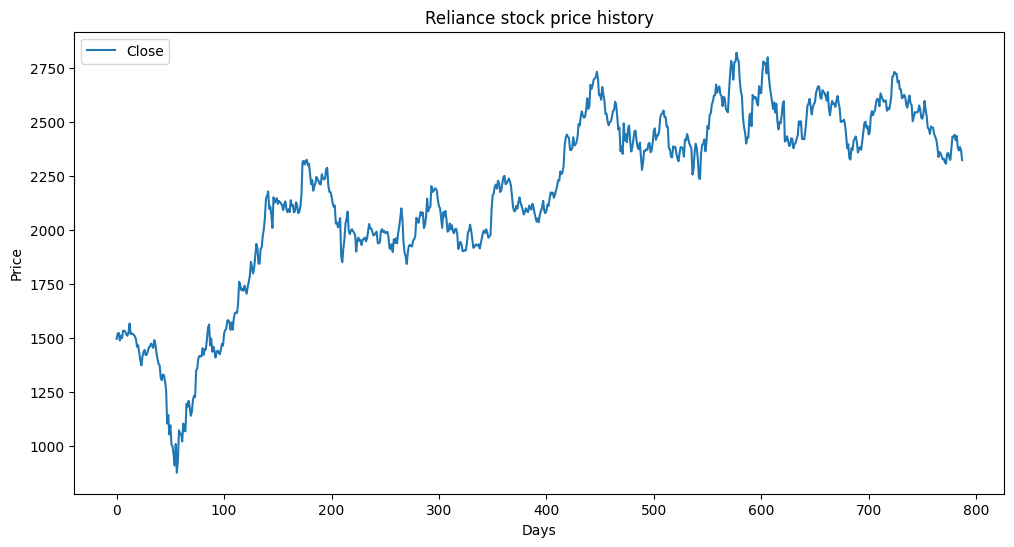

In [149]:
plt.figure(figsize = (12,6))
plt.plot(df1["Close"])
plt.title('Reliance stock price history')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Close'], loc='upper left')
plt.show()

In [150]:
ind=np.arange(789,827,1)
ind

array([789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801,
       802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814,
       815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826])

In [151]:
test_data=test_data.set_index(ind)

In [152]:
df1.drop('Date',axis=1)

,Close
0,1495.424927
1,1520.883545
2,1522.716187
3,1487.400879
4,1510.284058
...,...
783,2378.899902
784,2367.500000
785,2383.699951
786,2367.850098


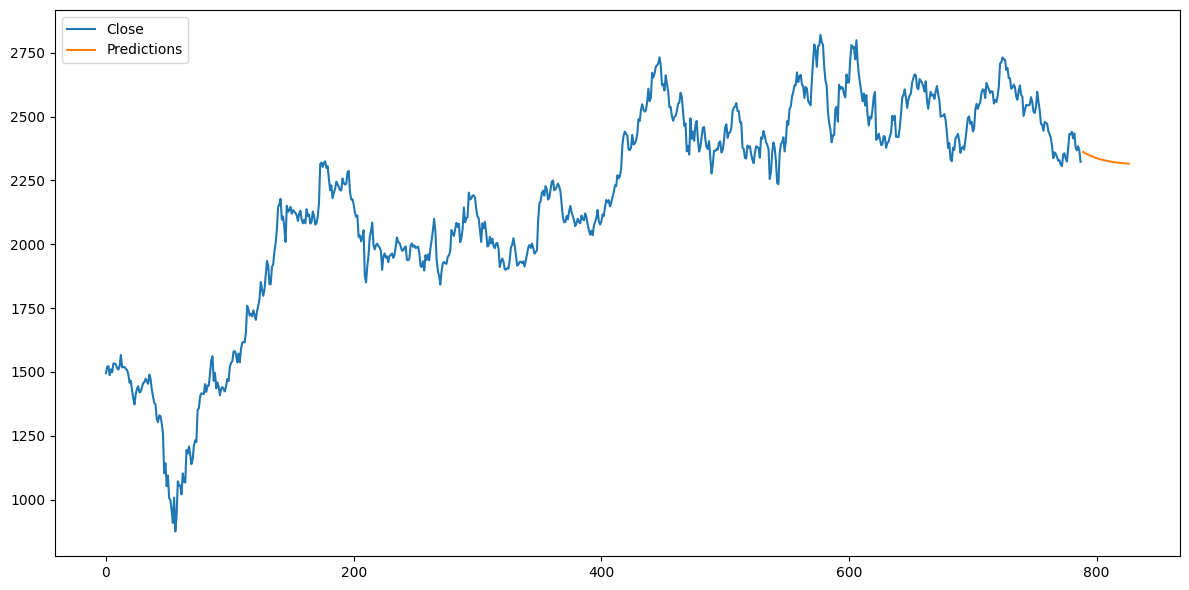

In [153]:
plt.figure(figsize = (12,6))
plt.plot(df1['Close'],label ='Actual Values')
plt.plot(test_data['Predictions'], label  ='Predictions')
plt.legend(['Close','Predictions'], loc='upper left')
plt.tight_layout()
plt.show()